In [10]:
import sys
sys.path.append("/home/isabrah/sustainable_high_quality_wikis")
import pandas as pd
from os.path import join as opj
import glob
from modeling_utils import meta_and_editing_structural_features_extractor, was_really_demoted
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [2]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

usecase = 'fa' # 'ga'
data_folder = '/shared/3/projects/relationship-aware-networks-wikipedia/wiki_generated_data/'
output_folder = '/shared/3/projects/relationship-aware-networks-wikipedia/models'
metadata_files_folder = opj(data_folder, 'meta_data')
pickle_files_folder = opj(data_folder, 'article_assessment_objs', 'good_articles') \
    if usecase == 'ga' else opj(data_folder, 'article_assessment_objs', 'featured_articles')
# in both cases of good/featured, we have to add the 'both' folder
pickle_files_folder = [pickle_files_folder, opj(data_folder, 'article_assessment_objs', 'both')]
until_promotion = True # if True, only revisions until promotion time are counted. Promotion date depends on the usecase
max_revisions_to_use = None # if None, we use until_promotion indicator. If both are turned off, we take the whole data

n_cpus = 100

In [3]:
pickle_files_path = sorted(list(itertools.chain(*[glob.glob(opj(pff, '*.p')) for pff in pickle_files_folder])))
data_df, unreliable_cases = (
        meta_and_editing_structural_features_extractor(files_path=pickle_files_path, usecase=usecase, cpus_to_use=n_cpus,
                                                       extract_meta=True, extract_creation_date=True,
                                                       extract_structural=False, max_revisions_to_use=max_revisions_to_use))

Meta and editing structural feature extraction ended. Created dataset shape: (7919, 12). Elapsed time (sec.): 28.


In [21]:
# we extract the year in which the page has been created and promoted
# one of the things I am interested in is the promotion year date. This is useful since we decided to filter articles based on promotion date
# this information is stored in last_revision_timestamp.
data_df['creation_year'] = pd.DatetimeIndex(data_df['creation_date']).year
data_df['promotion_year'] = pd.DatetimeIndex(data_df['last_revision_timestamp']).year
data_df.iloc[0]

last_revision_timestamp                  2005-08-16T22:01:45Z
is_sustained                                            False
meta_num_authors                                         69.0
meta_num_authors_normalized                          0.237931
meta_num_revisions                                      290.0
meta_num_revisions_normalized                        0.277512
meta_promotion_age                                       1045
edits_used_to_be_good_article                           False
dynamics_author_gini                                  0.63275
dynamics_reverts_perc                                0.032028
dynamics_ip_based_users_revision_perc                0.168966
creation_date                             2002-10-06 15:35:57
creation_year                                            2002
promotion_year                                           2005
Name: 100061, dtype: object

In [20]:
print(np.median(data_df[data_df['is_sustained']]['meta_promotion_age']))
print(np.median(data_df[data_df['is_sustained']]['meta_promotion_age']))
print(np.median(data_df[~data_df['is_sustained']]['meta_promotion_age']))
print(Counter(data_df['is_sustained']))

1763.0
1174.5
Counter({True: 6445, False: 1474})


### plotting the number of promoted articles over the years

In [22]:
# Group by the 'group' column
grouped = data_df.groupby('promotion_year')

# Calculate the percentage of True values in the 'value' column for each group
percentage_true = grouped['is_sustained'].mean() * 100

# Count the number of rows in each group
count_rows = grouped.size()

# Combine into a single DataFrame
result = pd.DataFrame({
    'percentage_true': percentage_true,
    'count_rows': count_rows
}).reset_index()
result

,promotion_year,percentage_true,count_rows
0,2001,50.931677,483
1,2002,50.000000,4
2,2003,44.444444,36
3,2004,59.740260,231
4,2005,74.431818,352
5,2006,23.847695,499
6,2007,60.087719,684
7,2008,84.532925,653
8,2009,90.818363,501
9,2010,95.783133,498


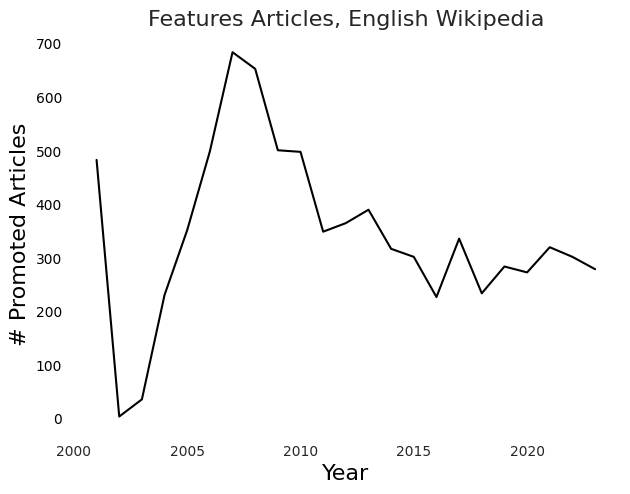

In [24]:
# let's plot
# Plotting with two y-axes
fig, ax1 = plt.subplots()
# Set white background
fig.patch.set_facecolor('white')
ax1.set_facecolor('white')

color = 'black'
ax1.set_ylabel('# Promoted Articles', color=color, fontsize=16)
ax1.set_xlabel('Year', color=color, fontsize=16)
ax1.plot(result['promotion_year'], result['count_rows'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Features Articles, English Wikipedia', fontsize=16)
plt.show()

### plotting the % of created articles over the years

In [28]:
# plotting the % of sustained articles over the years
# Group by the 'group' column
grouped = data_df.groupby('promotion_year')
grouped = data_df.groupby('creation_year')

# Calculate the percentage of True values in the 'value' column for each group
percentage_true = grouped['is_sustained'].mean() * 100

# Count the number of rows in each group
count_rows = grouped.size()

# Combine into a single DataFrame
result = pd.DataFrame({
    'percentage_true': percentage_true,
    'count_rows': count_rows
}).reset_index()
result

,creation_year,percentage_true,count_rows
0,2001,73.584906,106
1,2002,74.786460,3161
2,2003,84.683920,2357
3,2004,89.522452,4209
4,2005,92.631367,4967
5,2006,92.717087,4641
6,2007,93.425708,3392
7,2008,93.285658,2517
8,2009,95.271150,2305
9,2010,95.373134,2010


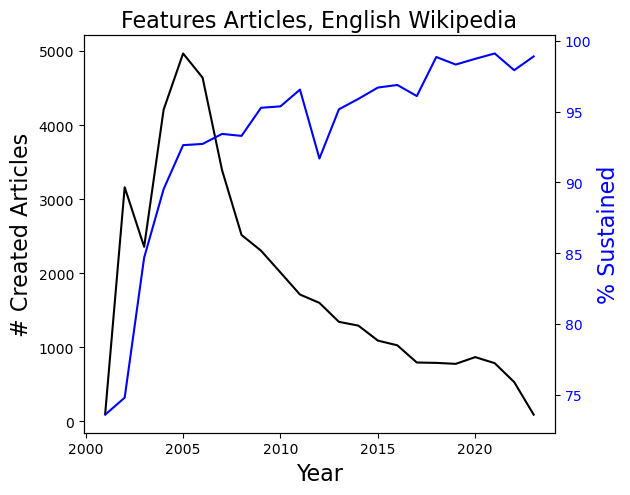

In [29]:
# let's plot
# Plotting with two y-axes
fig, ax1 = plt.subplots()
# Set white background
fig.patch.set_facecolor('white')
ax1.set_facecolor('white')

color = 'black'
ax1.set_ylabel('# Created Articles', color=color, fontsize=16)
ax1.set_xlabel('Year', color=color, fontsize=16)
ax1.plot(result['creation_year'], result['count_rows'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_facecolor('white')  # Ensure the second axes also has a white background

color = 'blue'
ax2.set_xlabel('Year')
ax2.set_ylabel('% Sustained', color=color, fontsize=16)
ax2.plot(result['creation_year'], result['percentage_true'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Features Articles, English Wikipedia', fontsize=16)
plt.show()

The average :: median number of days from birth to promotion is 2004.67 :: 1511.0


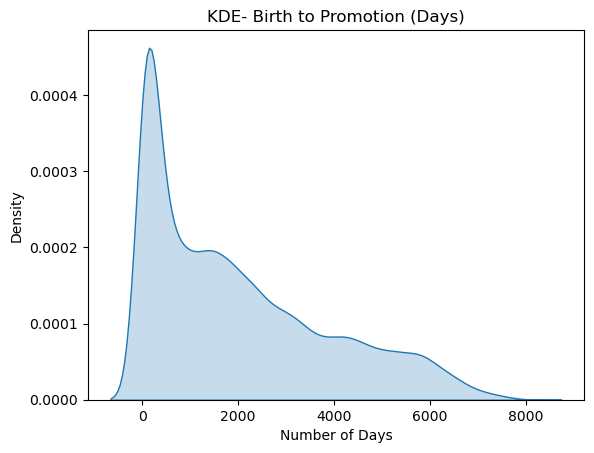

In [30]:
avg_birth_to_promotion = np.round(np.nanmean(data_df['promotion_age']), 2)
median_birth_to_promotion = np.round(np.nanmedian(data_df['promotion_age']), 2)
print(f"The average :: median number of days from birth to promotion is {avg_birth_to_promotion} :: {median_birth_to_promotion}")
sns.kdeplot(data_df['promotion_age'], fill=True)
plt.xlabel('Number of Days')
plt.ylabel('Density')
plt.title('KDE- Birth to Promotion (Days)')
plt.show()